## Setup and Import Libraries

In [2]:
import os
import umap
import matplotlib.pyplot as plt
from openai import OpenAI
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from utils import load_chroma, word_wrap, project_embeddings
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

In [3]:
load_dotenv()

True

In [4]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [5]:
openai_client = OpenAI()

## Loading Chroma

In [6]:
embedding_function = SentenceTransformerEmbeddingFunction()

In [7]:
chroma_collection = load_chroma(
    filename='data/microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022', 
    embedding_function=embedding_function
)

chroma_collection.count()

349

## Projecting Embeddings

In [8]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [9]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [00:04<00:00, 71.01it/s] 


## Expansion with Generated Answer

In [10]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": """You are a helpful expert financial research assistant. 
            Provide an example answer to the given question, that might be found in a document like an annual report. """
        },
        {
            "role": "user",
            "content": query
        }
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    
    content = response.choices[0].message.content
    return content

In [11]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past
fiscal year, our executive team experienced minimal turnover. There
were no departures of any key senior executives during this period. Our
leadership team remained stable, providing continuity in strategic
decision-making and ensuring a seamless execution of our business
plans.


In [12]:
results = chroma_collection.query(
    query_texts=joint_query,
    n_results=5,
    include=['documents', 'embeddings']
)

retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

to be their authentic selves and do their best work every day. we
support multiple highly active employee resource groups for women,
families, racial and ethnic minorities, military, people with
disabilities, and employees who identify as lgbtqia +, where employees
can go for support, networking, and community - building. as described
in our 2021 proxy statement, annual performance and compensation
reviews of our senior leadership team include an evaluation of their
contributions to employee culture and diversity. to ensure
accountability over time, we publicly disclose our progress on a
multitude of workforce metrics including : • detailed breakdowns of
gender, racial, and ethnic minority representation in our employee
population, with data by job types, levels, and segments of our
business. • our eeo - 1 report ( equal employment opportunity ). •
disability representation. • pay equity ( see details below ).

unresolved with the irs, evaluating management ’ s estimates relating
to th

In [13]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 475.83it/s]


(np.float64(-0.18404115810990335),
 np.float64(9.099320054799318),
 np.float64(4.4927960395812985),
 np.float64(13.121015453338623))

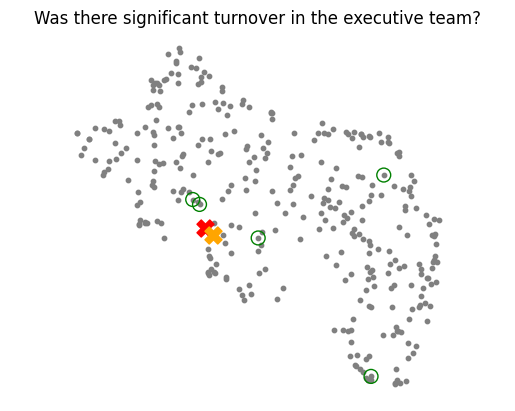

In [14]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with Multiple Queries

In [15]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {
            "role": "user",
            "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    
    content = response.choices[0].message.content
    content = content.split("\n")
    
    return content

In [16]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

What were the key highlights in the company's financial performance for the year?  
Can you provide details on the revenue breakdown by segments or regions?  
What strategies did the company implement to drive revenue growth?  
What were the main drivers behind the increase in revenue for the year?  
How did changes in market conditions impact the company's revenue performance?  


In [17]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

In [18]:
retrieved_documents = results['documents']

In [19]:
unique_documents = set()

for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

In [20]:
for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [21]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 423.21it/s]


In [22]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

100%|██████████| 30/30 [00:00<00:00, 525.99it/s]


(np.float64(-0.18404115810990335),
 np.float64(9.099320054799318),
 np.float64(4.4927960395812985),
 np.float64(13.121015453338623))

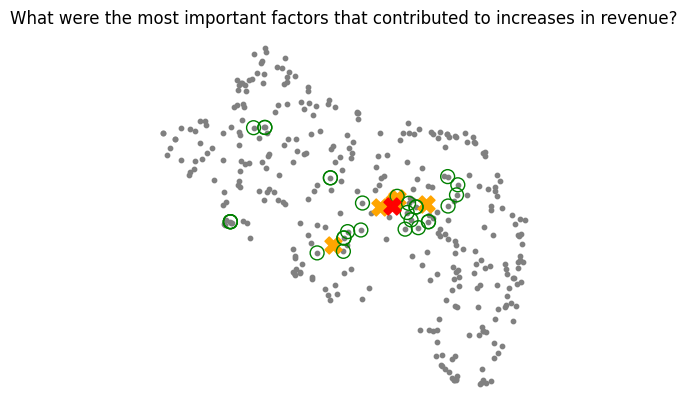

In [23]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')